# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## Finishing off with Random Forests & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [6]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [8]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [9]:
# This next line takes an hour on my M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [11]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [12]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [13]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [14]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [15]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $266.15 Truth: $374.41 Error: $108.26 SLE: 0.12 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $206.65 Truth: $225.11 Error: $18.46 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $239.61 Truth: $61.68 Error: $177.93 SLE: 1.81 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $329.18 Truth: $599.99 Error: $270.81 SLE: 0.36 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $221.50 Truth: $16.99 Error: $204.51 SLE: 6.33 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $119.08 Truth: $31.99 Error: $87.09 SLE: 1.67 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $283.21 Truth: $101.79 Error: $181.42 SLE: 1.03 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $248.01 Truth: $289.00 Error: $40.99 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $325.50 Truth: $635.86 Error: $310.36 SLE: 0.45 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $178.37 Truth: $65.99 Error: $112.38 S

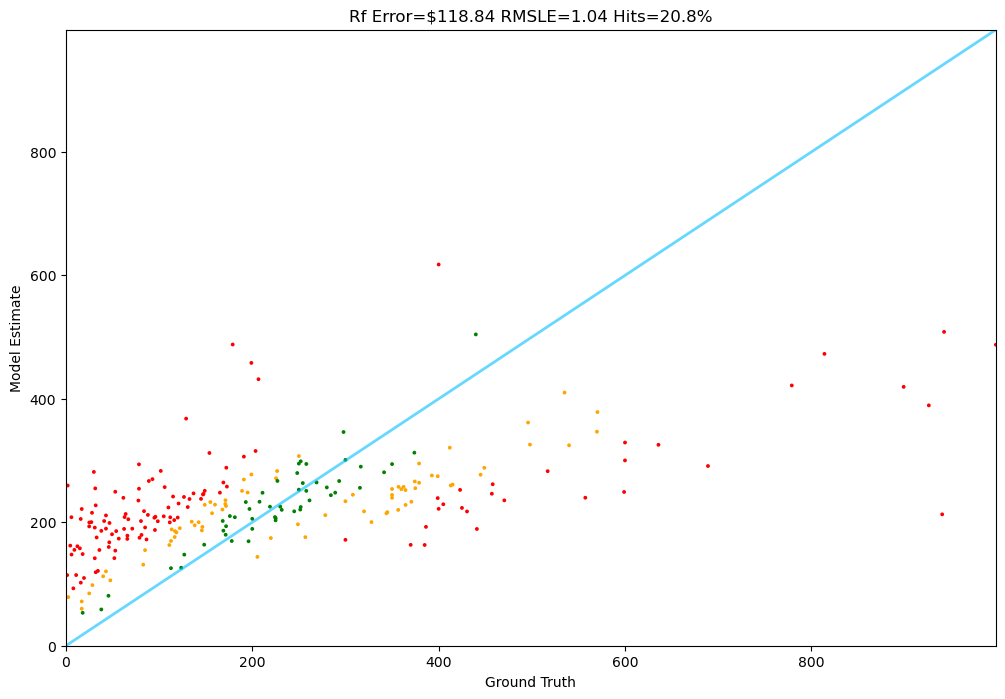

In [16]:
Tester.test(rf, test)

In [17]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [18]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

89.0
139.99
294.6797000000002


In [19]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [12:28<00:00,  2.99s/it]


In [20]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [21]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.69
Frontier: 0.79
RandomForest: 0.27
Min: -0.29
Max: -0.44
Intercept=39.66


In [22]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [23]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [24]:
ensemble.price(product)

135.68711037024414

In [25]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $348.54 Truth: $374.41 Error: $25.87 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $157.55 Truth: $225.11 Error: $67.56 SLE: 0.13 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.03 Truth: $61.68 Error: $16.65 SLE: 0.10 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $388.92 Truth: $599.99 Error: $211.07 SLE: 0.19 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $28.48 Truth: $16.99 Error: $11.49 SLE: 0.24 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $32.34 Truth: $31.99 Error: $0.35 SLE: 0.00 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $193.40 Truth: $101.79 Error: $91.61 SLE: 0.41 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $322.55 Truth: $289.00 Error: $33.55 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $606.05 Truth: $635.86 Error: $29.81 SLE: 0.00 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $120.72 Truth: $65.99 Error: $54.73 SLE: 0.36 I

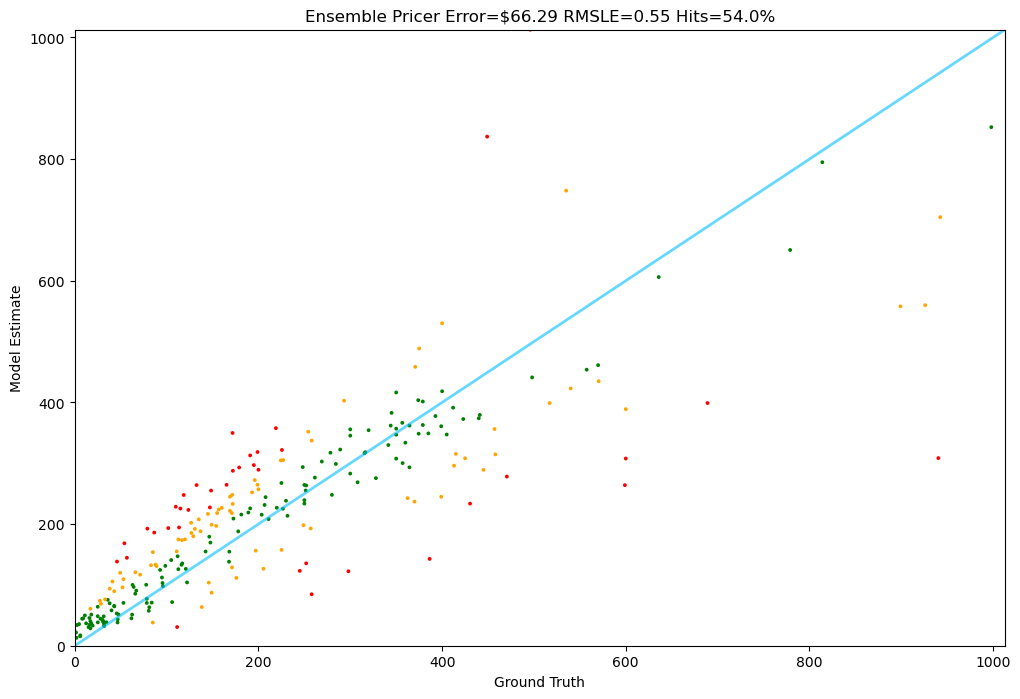

In [26]:
Tester.test(ensemble_pricer, test)

# WHAT A DAY!

We got so much done - a Fronter RAG pipeline, a Random Forest model using transformer-based encodings, and an Ensemble model.

You can do better, for sure!

Tweak this, and try adding components into the ensemble, to beat my performance.